In [43]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [44]:
IMAGE_SIZE = 256 #height and width dimension
BATCH_SIZE = 32 #number of samples to be used in training in each iteration
CHANNELS = 3 #RGB values
EPOCHS = 50 #number of times model will pass through entire dataset during training

In [45]:
from google.colab import drive
drive.mount('/content/drive/')
dataset_folder = 'content/drive/MyDrive/Chilis'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [12]:
#DYNAMIC RESIZING
# def dynamic_resize(image, target_size):
#     height, width = tf.shape(image)[0], tf.shape(image)[1]
#     new_height, new_width = target_size

#     # Calculate aspect ratios of the old and new image sizes
#     aspect_ratio = tf.cast(width, tf.float32) / tf.cast(height, tf.float32)
#     new_aspect_ratio = tf.cast(new_width, tf.float32) / tf.cast(new_height, tf.float32)

#     # Calculate the new image size that maintains the original aspect ratio
#     if aspect_ratio < new_aspect_ratio:
#         new_width = tf.cast(new_height * aspect_ratio, tf.int32)
#     else:
#         new_height = tf.cast(new_width / aspect_ratio, tf.int32)

#     # Resize the image to the new size while maintaining aspect ratio
#     image = tf.image.resize(image, [new_height, new_width])
#     return image

DATA PRE-PROCESSING

In [46]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/MyDrive/Chilis',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 500 files belonging to 5 classes.


In [47]:
classNames = dataset.class_names
classNames

['Chili__healthy',
 'Chili__leaf curl',
 'Chili__leaf spot',
 'Chili__whitefly',
 'Chili__yellowish']

In [23]:
len(dataset)

16

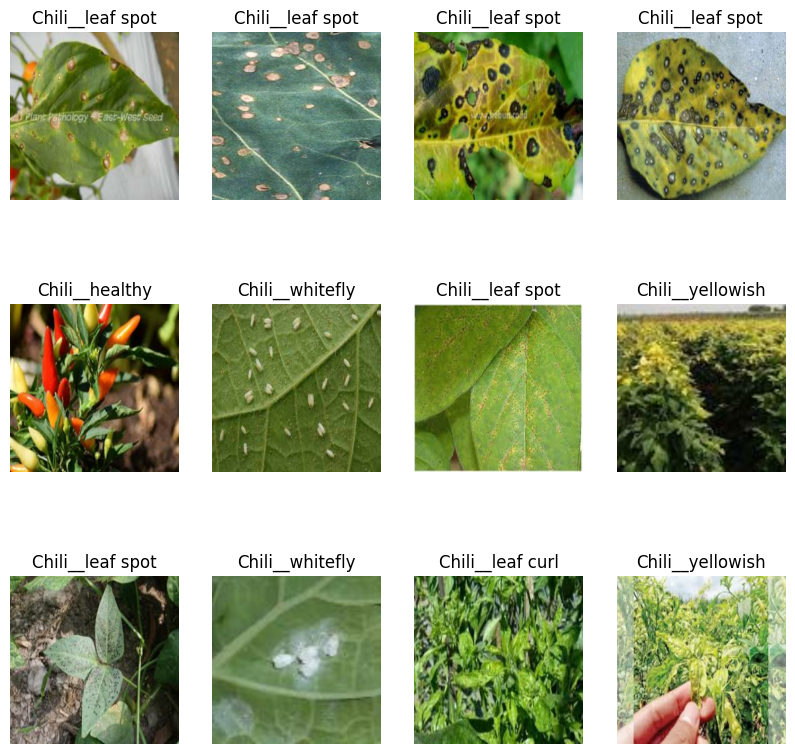

In [48]:
plt.figure(figsize = (10,10))
for image_batch, label_batch  in dataset.take(1):
  #takes only 1 batch, hence the '1'
  for i in range(12):
    layout = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(classNames[label_batch[i]])
    plt.axis('off')
  #'3' in the output represents the channels - rgb

In [ ]:
 #SPLITTING THE DATASET

In [49]:
len(dataset)

16

In [ ]:
#80% ==> training
#20% ==> 10% validation, 10% test

In [50]:
trainSize = 0.8
len(dataset)* trainSize

12.8

In [51]:
trainDS = dataset.take(14)
len(trainDS)

14

In [52]:
testDS = dataset.skip(14) #same as saying arr(14:)
len(testDS)

2

In [53]:
#Validation dataset
valSize = 0.1
len(dataset)* valSize

1.6

In [54]:
valDS = testDS.take(2)
len(valDS)

2

In [55]:
testDS = testDS.skip(1)
len(testDS)

1

In [56]:
def get_dataset_partitions_tf(ds, trainSplit=0.8, valSplit = 0.1, testSplit=0.1, shuffle='true', shuffleSize=10000):
  dsSize = len(ds)

  #Before we split out dataset, we shuffle it.
  if shuffle:
    ds = ds.shuffle(shuffleSize, seed = 12)


  trainSize = int(trainSplit*dsSize)
  valSize = int(dsSize*valSplit)

  trainDs = ds.take(trainSize)
  valDS = ds.skip(trainSize).take(valSize)
  testDS = ds.skip(trainSize).skip(valSize)
  return trainDS, valDS, testDS

In [57]:
trainDS, valDS, testDS = get_dataset_partitions_tf(dataset)

In [58]:
len(trainDS)


14

In [59]:
len(valDS)


1

In [60]:
len(testDS)

3

In [ ]:
#CACHING AND PRE-FETCHING. THESE TWO PROCESSES ARE DONE TO OPTIMIZE TRAINING OF THE MODEL

In [61]:
trainDS = trainDS.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
valDS = valDS.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
testDS = testDS.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [62]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),#we are resizing our images again here because new images obtained during prediction may not be 256 by 256
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
#DATA AUGMENTATION

In [63]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
#MODEL BUILDING

In [64]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
nClasses = 3
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    # fliters are used for image detection. Eg. a filter to detect the nose, onother for eyes etc to decide if an image is a cat or a dog
    # Pooling is used to reduce the size of the image while maintaining its features
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(nClasses, activation = 'softmax'),
])
model.build(input_shape = input_shape)

In [65]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [ ]:
# optimizers are important during the learning process of a model to help the model make more accurate predictions

In [66]:
# optimizers make models efficient by reducing the loss
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
# model training

In [67]:
history = model.fit(
    trainDS,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    # after each epoch, validation is done
    validation_data = valDS
)
# 'loss' means the amount of data loss

Epoch 1/50
14/14 [==============================] - 27s 143ms/step - loss: nan - accuracy: 0.2098 - val_loss: nan - val_accuracy: 0.1875
Epoch 2/50
14/14 [==============================] - 1s 55ms/step - loss: nan - accuracy: 0.1987 - val_loss: nan - val_accuracy: 0.1875
Epoch 3/50
14/14 [==============================] - 1s 55ms/step - loss: nan - accuracy: 0.1987 - val_loss: nan - val_accuracy: 0.1875
Epoch 4/50
14/14 [==============================] - 1s 55ms/step - loss: nan - accuracy: 0.1987 - val_loss: nan - val_accuracy: 0.1875
Epoch 5/50
14/14 [==============================] - 1s 55ms/step - loss: nan - accuracy: 0.1987 - val_loss: nan - val_accuracy: 0.1875
Epoch 6/50
14/14 [==============================] - 1s 55ms/step - loss: nan - accuracy: 0.1987 - val_loss: nan - val_accuracy: 0.1875
Epoch 7/50
14/14 [==============================] - 1s 55ms/step - loss: nan - accuracy: 0.1987 - val_loss: nan - val_accuracy: 0.1875
Epoch 8/50
14/14 [==============================] - 1

In [ ]:
# Plot training history on graph

In [68]:
# Tryubg to see how well the model will predict using new data
scores = model.evaluate(testDS)

3/3 [==============================] - 1s 30ms/step - loss: nan - accuracy: 0.1979


In [69]:
# when you print the variable alone, it will give the last 2 parameters, ie, loss and accuraacy
scores

[nan, 0.1979166716337204]

In [70]:
# this provides the list of parameters printed when training the model
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [71]:
# 'history is used to give the history of parameter values like shown below.
history.history['accuracy']

[0.2098214328289032,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164144516,
 0.1986607164

In [ ]:
#plotting the parameters using matplotlib

In [72]:
#Storing the parameters in variables
loss = history.history['loss']
accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

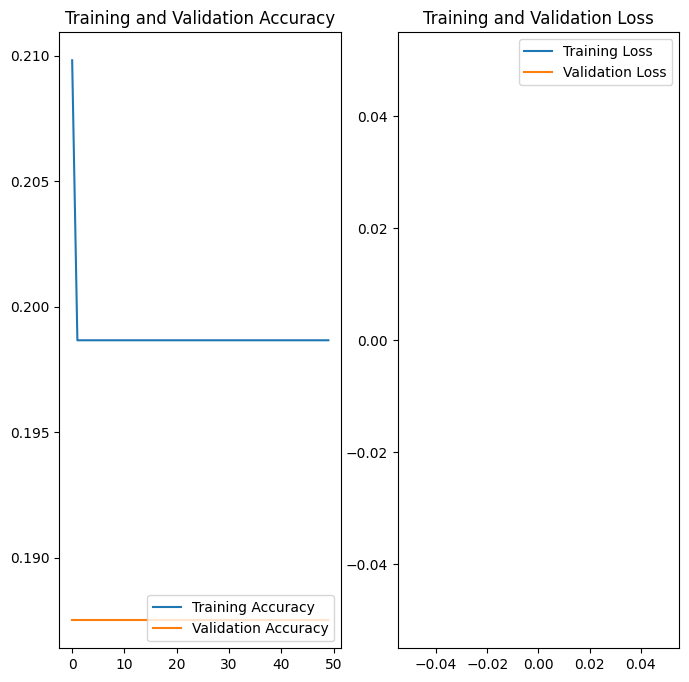

In [73]:
#plotting history of parameters using matplotlib
#The Accuracy Chart
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

#The loss Chart
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

first image to predict
actual label Chili__healthy
1/1 [==============================] - 0s 35ms/step
predicted label: Chili__healthy


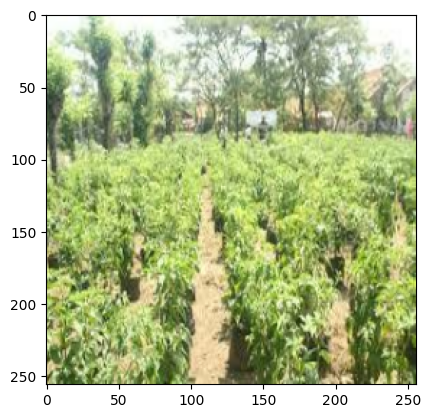

In [81]:
import numpy as np
for images_batch, labels_batch in testDS.take(1):
  first_image = images_batch[0].numpy().astype('uint8')
  first_label = labels_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label',classNames[first_label])

  batch_prediction=model.predict(images_batch)
  print("predicted label:",classNames[np.argmax(batch_prediction[0])])